In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [58]:
config_df = pd.read_csv("bert_classifier_indo.csv")
config_df = config_df.iloc[2:-1]
epoch_df = pd.read_csv("bert_classifier_indo_epoch.csv")
epoch_df.head()
config_df.head()

,config_id,type_test,model_name,dataset_type,batch_size,epochs,learning_rate,attention_dropout,hidden_dropout,classifier_dropout,weight_decay,training_time,peak_memory,test_mse,test_mae,test_rmse,test_pearson
2,2,classifier,indobenchmark/indobert-lite-base-p2,before balancing,16,15,0.00002,0,0,0.1,0.01,3054.004202,4907.419434,0.011154,0.081609,0.105614,0.916710
3,3,classifier,indobenchmark/indobert-lite-base-p2,after balancing,16,10,0.00002,0,0,0.1,0.01,3748.259584,4907.419434,0.010455,0.078663,0.102249,0.925008


# Training Plot

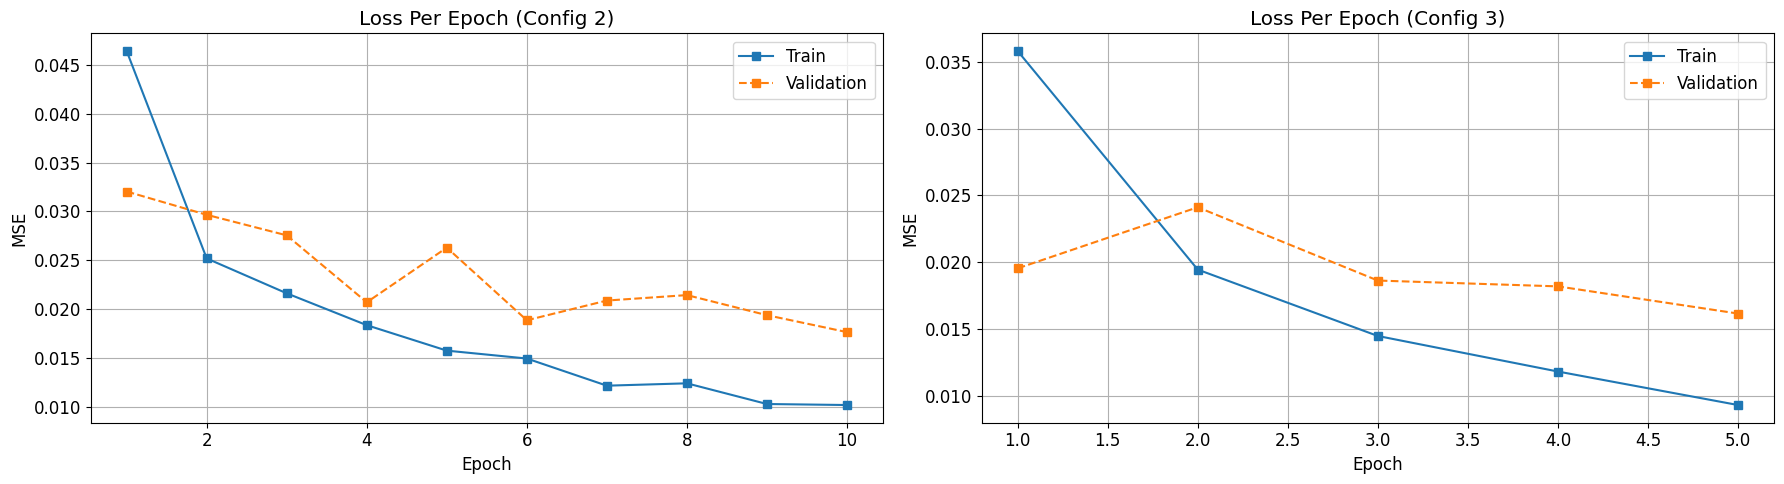

In [ ]:
metrics = ['mse']
titles = {
    'mse': 'Loss Per Epoch'
}

fig, axes = plt.subplots(1, 2, figsize=(18, 5))  

for i, row in enumerate(config_df.itertuples(index=False)):
    
    config_id = row.config_id
    data = epoch_df[epoch_df['config_id'] == config_id]
    
    epochs = data['epoch'].iloc[:-5]
    
    for metric in metrics:
        train_metric = data[f'train_{metric}'].iloc[:-5]
        valid_metric = data[f'valid_{metric}'].iloc[:-5]

        ax = axes[i]
        ax.plot(epochs, train_metric, linestyle='-', marker='s', label='Train')
        ax.plot(epochs, valid_metric, linestyle='--', marker='s', label='Validation')
        
        ax.set_title(f"{titles[metric]} (Config {config_id})")
        ax.set_xlabel("Epoch")
        ax.set_ylabel(metric.upper())
        ax.legend()
        ax.grid(True)

plt.tight_layout()
plt.show()


In [60]:
import sys
import os
src_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', '..'))
sys.path.append(src_path)
from transformers import BertTokenizer
from main_regression import RegressionModel, AutomaticScoringDataset
from torch.utils.data import DataLoader
import torch

tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-lite-base-p2')
model = RegressionModel('indobenchmark/indobert-lite-base-p2', pooling_type='cls').to('cuda')
def predict(df_test, config_id):
    test_data = AutomaticScoringDataset(df_test, tokenizer)
    test_dataloader = DataLoader(test_data, batch_size=16, shuffle=False, generator=torch.Generator().manual_seed(42), num_workers=0)
    
    checkpoint = torch.load(f"../../../models/balancing/cross/bert_classifier_indo_{config_id}.pt", map_location='cuda', weights_only=True)
    model.load_state_dict(checkpoint)
    model.eval()
    all_predictions = []
    all_targets = []
    with torch.no_grad():
        for batchs in test_dataloader:
            try:
                # move to device
                batchs = {k: v.to('cuda') for k, v in batchs.items()}
                predictions = model(
                    batchs['input_ids'], 
                    batchs['attention_mask'], 
                    batchs['token_type_ids']).squeeze(1)
                preds = torch.clamp(predictions, 0, 1)

                all_predictions.extend(preds.detach().cpu().numpy())
                all_targets.extend(batchs['labels'].detach().cpu().numpy())
            except Exception as e:
                torch.cuda.empty_cache()

    return all_predictions, all_targets

def save_predictions(df_test, output_path):
    columns_to_keep = ['question', 'reference_answer', 'answer', 'normalized_score', 'dataset_num']
    columns_to_keep += [col for col in df_test.columns if col.startswith("predicted_score_")]
    df_test = df_test[columns_to_keep]
    df_test.to_csv(output_path, index=False)

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'AlbertTokenizer'. 
The class this function is called from is 'BertTokenizer'.
Some weights of the model checkpoint at indobenchmark/indobert-lite-base-p2 were not used when initializing AlbertModel: ['pooler.bias', 'pooler.weight']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [61]:
import pandas as pd

df_test = pd.read_csv("../../../../data/clean/cross/test_indo.csv")
for row in config_df.itertuples():
    all_predictions, all_targets = predict(df_test, row.config_id)

    # Tambahkan prediksi ke df_test
    df_test[f"predicted_score_{row.config_id}"] = all_predictions

output_dir = "inference"
os.makedirs(output_dir, exist_ok=True)

save_predictions(df_test, os.path.join(output_dir, "bert_predictions_indo1.csv"))


>> Tanpa Augmentasi - predicted_score_2
RMSE: 0.1056, Pearson: 0.9167

>> Dengan Augmentasi - predicted_score_3
RMSE: 0.1022, Pearson: 0.9250


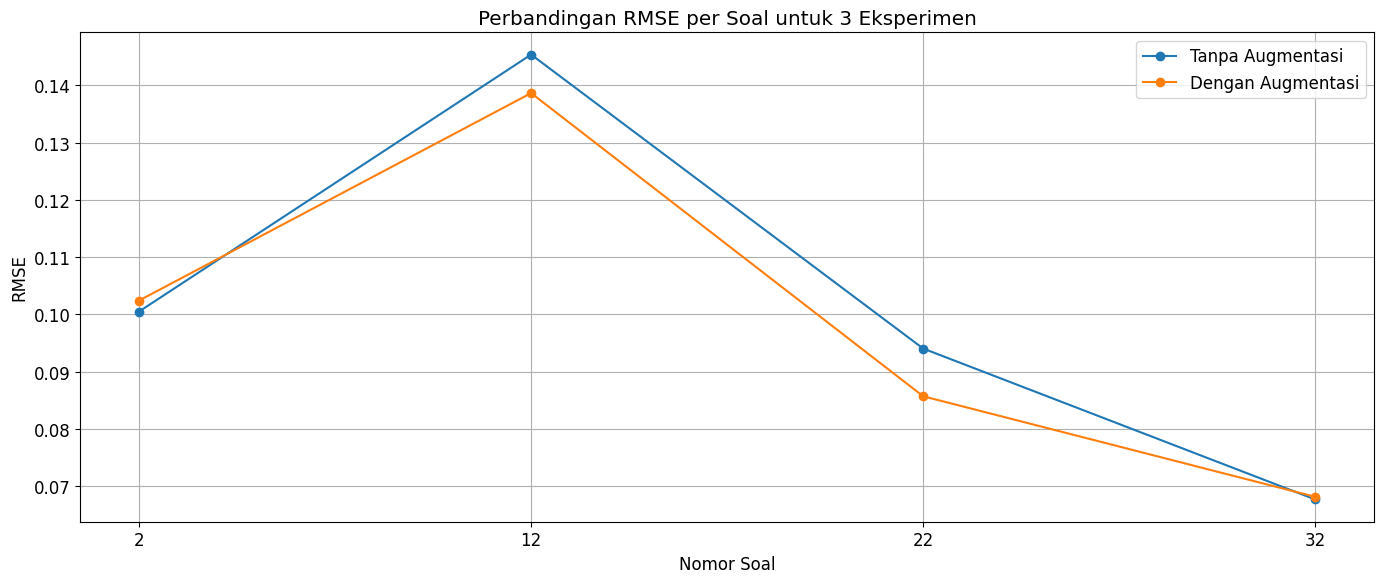

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import root_mean_squared_error
from scipy.stats import pearsonr
from tabulate import tabulate

inference_dir = "inference"
csv_files = [f for f in os.listdir(inference_dir) if f.endswith(".csv") and f.startswith("bert")]

color_palette = plt.get_cmap("tab10")  

label_map = {
    "predicted_score_2": "Tanpa Augmentasi",
    "predicted_score_3": "Dengan Augmentasi"
}

rmse_per_model = {}
metric_eval_data = {}
model_idx = 0
for file in csv_files:
    file_path = os.path.join(inference_dir, file)
    df = pd.read_csv(file_path)

    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores

        rmse = root_mean_squared_error(true_scores, pred_scores)
        pearson, _ = pearsonr(true_scores, pred_scores)

        label = label_map.get(col, col) 
        print(f"\n>> {label} - {col}")
        print(f"RMSE: {rmse:.4f}, Pearson: {pearson:.4f}")

        metric_eval_data[label] = {
            "RMSE": round(rmse, 4),
            "Pearson": round(pearson, 4)
        }

        rmse_per_soal = df.groupby('dataset_num').apply(lambda x: root_mean_squared_error(x['normalized_score'], x[col]), include_groups=False)
        rmse_per_model[label] = rmse_per_soal
        model_idx += 1

def extract_soal_number(index_series):
    return index_series.astype(str).str.extract(r'(\d+)$').astype(int)[0]

plt.figure(figsize=(14, 6))
for i, label in enumerate(rmse_per_model):
    rmse_series = rmse_per_model[label]
    
    soal_numbers = extract_soal_number(rmse_series.index)
    
    rmse_series.index = soal_numbers
    rmse_series = rmse_series.sort_index()
    
    plt.plot(rmse_series.index, rmse_series.values, marker='o', linestyle='-', label=label)

plt.title("Perbandingan RMSE per Soal untuk 3 Eksperimen")
plt.xlabel("Nomor Soal")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.xticks(ticks=sorted(rmse_series.index.unique()))
plt.tight_layout()
plt.show()



In [ ]:
fixed_threshold = 0.1

model_data = []

for file in csv_files:
    df = pd.read_csv(os.path.join(inference_dir, file))
    true_scores = df['normalized_score'].values
    pred_cols = [col for col in df.columns if col.startswith("predicted_score_")]

    for col in pred_cols:
        pred_scores = df[col].values
        residuals = pred_scores - true_scores
        label = label_map.get(col, col)
        model_data.append((label, true_scores, pred_scores, residuals))

model_data = sorted(model_data, key=lambda x: x[0])

for i, (label, true_scores, pred_scores, residuals) in enumerate(model_data):
    outlier_fixed2 = np.abs(residuals) > 0.2
    outlier_fixed = np.abs(residuals) > fixed_threshold

    num_outliers_fixed2 = np.sum(outlier_fixed2)
    num_outliers_fixed = np.sum(outlier_fixed)

    print(f"{label}:")
    print(f"  Outlier (Fixed ±0.2): {num_outliers_fixed2}")
    print(f"  Outlier (Fixed ±{fixed_threshold}): {num_outliers_fixed}\n")

Dengan Augmentasi:
  Outlier (Fixed ±0.2): 13
  Outlier (Fixed ±0.1): 57

Tanpa Augmentasi:
  Outlier (Fixed ±0.2): 15
  Outlier (Fixed ±0.1): 64

